In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
from io import StringIO
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
def read_from_file(filename) :
    f = open(filename, 'r')
    lines = f.readlines()

    #appnames = []
    contents = []
    log = ''
    capture = False

    for line in lines:
        #if(line.isspace()): continue

        if(('AUL Launching' in line or 'Fork Launching' in line) and 'tv-viewer' not in line):
            capture = True
            appname = line.split('\"')[1]
            
        if(capture == True and ('app_id' in line or 'launch app' in line or 'spend time for' in line)) :
            continue

        if(capture == True and 'stablised' in line):
            sec = float(line.split(' ')[-1][0:-4])
            contents.append({'appname': appname, 'log': log, 'sec': sec})
            log = ''
            capture = False
            
        if(capture is True):
            log += line
            
    f.close()
    return contents

In [86]:
def draw_chart(contents):
    fig, axes = plt.subplots(len(contents), 1, figsize=(12, 16))
    fig.subplots_adjust(hspace=0.7)
    
    for i, content in enumerate(contents):
        frame = pd.read_csv(StringIO(content['log']), sep='\s+', skiprows=[0, 1])
        title = content['appname'] + ' ' + str(content['sec'])
        ax = frame[['tot.cpu', 'usr.cpu', 'kswapd']].plot(ax=axes[i], x=frame['time'], title=title, linewidth=2, legend=False)
        #ax.annotate("launching finish",
        #     (content['sec'], 30),
        #     xytext=(15, 15), 
        #     textcoords='offset points',
        #     arrowprops=dict(arrowstyle='-|>'))
        ymin, ymax = ax.get_ylim()
        ax.vlines(x=content['sec'], ymin=ymin, ymax=ymax-1, color='k', linewidth=3, linestyle='dashed')

In [73]:
def show(filename):
    contents = read_from_file(filename)
    draw_chart(contents)

In [74]:
def launching_time(filename):
    contents = read_from_file(filename)
    for content in contents:
        print(content['sec'], end='\t')

In [75]:
launching_time("../pr_disabled_20170522_105153.txt")

1.5	6.1	9.1	15.5	7.8	

In [76]:
launching_time("../pr_disabled_20170522_105530.txt")

5.7	5.8	7.9	14.0	

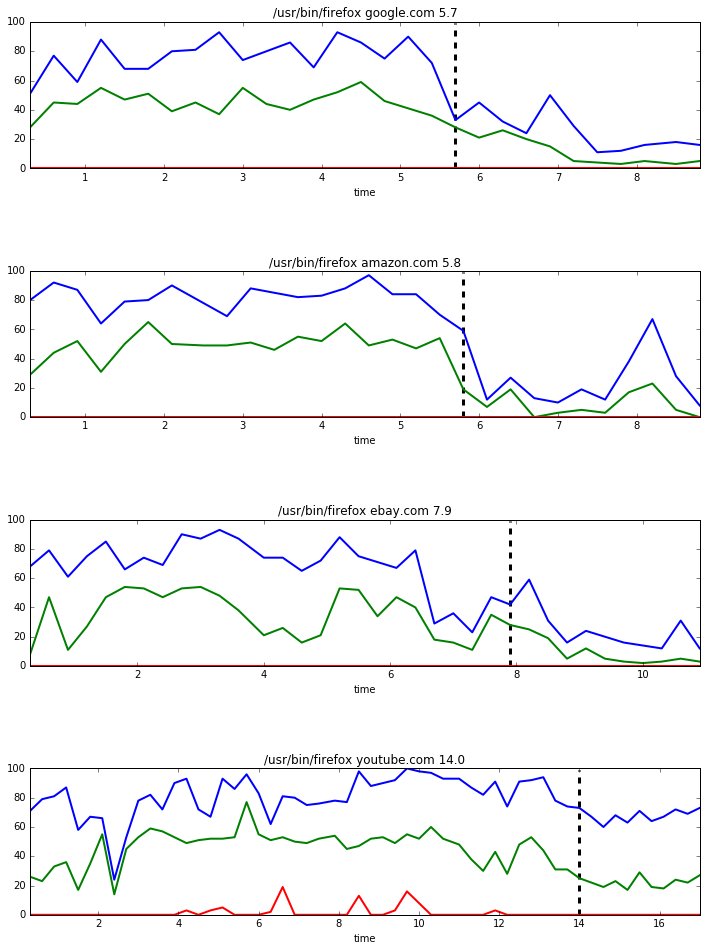

In [87]:
show("../pr_disabled_20170522_105530.txt")